In [1]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
import os
import matplotlib.pyplot as plt
import skimage.measure
import scipy.ndimage

from src.datasets import BiosensorDataset, create_datasets
from src.unet import UNet
from src.train import train_model

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device {device}')

torch.manual_seed(42)
np.random.seed(42)

data_path = 'data_with_centers/'
checkpoint_dir = 'checkpoints'
train_percent = 0.495
test_percent = 0.30
bio_len = 64
mask_size = 80
batch_size = 4

train_dataset, val_dataset, test_dataset = create_datasets(data_path, train_percent, bool, test_percent=test_percent, biosensor_length=bio_len, mask_size=mask_size, augment=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = UNet(n_channels=bio_len, n_classes=1)
model = model.to(device)

Using device cuda


In [32]:
try:
    train_model(
        model,
        device,
        train_loader,
        val_loader,
        learning_rate=0.01,
        epochs=15,
        checkpoint_dir=checkpoint_dir,
        amp=True,
        wandb_logging=False
    )
except torch.cuda.OutOfMemoryError:
    torch.cuda.empty_cache()
    print('Detected OutOfMemoryError!')

Starting training:
        Epochs:          15
        Batch size:      4
        Learning rate:   0.01
        Training size:   80
        Validation size: 35
        Device:          cuda
        Mixed Precision: True
    


Epoch 1/15: 100%|██████████| 80/80 [00:17<00:00,  4.48img/s, loss (batch)=0.964]


Validation Dice score: 0.22224418818950653, Detection rate: 0.26591075347476223
Checkpoint 1 saved!


Epoch 2/15: 100%|██████████| 80/80 [00:20<00:00,  3.93img/s, loss (batch)=0.73] 


Validation Dice score: 0.2949659526348114, Detection rate: 0.5596196049743964
Checkpoint 2 saved!


Epoch 3/15: 100%|██████████| 80/80 [00:15<00:00,  5.05img/s, loss (batch)=0.732]


Validation Dice score: 0.33627158403396606, Detection rate: 0.6221653255303584
Checkpoint 3 saved!


Epoch 4/15: 100%|██████████| 80/80 [00:15<00:00,  5.03img/s, loss (batch)=0.812]


Validation Dice score: 0.37752917408943176, Detection rate: 0.6850768105340161
Checkpoint 4 saved!


Epoch 5/15: 100%|██████████| 80/80 [00:15<00:00,  5.11img/s, loss (batch)=0.697]


Validation Dice score: 0.4066203534603119, Detection rate: 0.7468910021945867
Checkpoint 5 saved!


Epoch 6/15: 100%|██████████| 80/80 [00:16<00:00,  4.92img/s, loss (batch)=0.719]


Validation Dice score: 0.40421998500823975, Detection rate: 0.7220190197512801
Checkpoint 6 saved!


Epoch 7/15: 100%|██████████| 80/80 [00:15<00:00,  5.08img/s, loss (batch)=0.641]


Validation Dice score: 0.3515399992465973, Detection rate: 0.7688368690563278
Checkpoint 7 saved!


Epoch 8/15: 100%|██████████| 80/80 [00:15<00:00,  5.01img/s, loss (batch)=0.677]


Validation Dice score: 0.41272488236427307, Detection rate: 0.7790782735918069
Checkpoint 8 saved!


Epoch 9/15: 100%|██████████| 80/80 [00:15<00:00,  5.22img/s, loss (batch)=0.806]


Validation Dice score: 0.4202784597873688, Detection rate: 0.7735918068763716
Checkpoint 9 saved!


Epoch 10/15: 100%|██████████| 80/80 [00:15<00:00,  5.05img/s, loss (batch)=0.832]


Validation Dice score: 0.4374597370624542, Detection rate: 0.8068763716166789
Checkpoint 10 saved!


Epoch 11/15: 100%|██████████| 80/80 [00:15<00:00,  5.04img/s, loss (batch)=0.79] 


Validation Dice score: 0.4307698905467987, Detection rate: 0.8072421360643746
Checkpoint 11 saved!


Epoch 12/15: 100%|██████████| 80/80 [00:15<00:00,  5.01img/s, loss (batch)=0.78] 


Validation Dice score: 0.39706456661224365, Detection rate: 0.768471104608632
Checkpoint 12 saved!


Epoch 13/15: 100%|██████████| 80/80 [00:15<00:00,  5.08img/s, loss (batch)=0.727]


Validation Dice score: 0.3975202143192291, Detection rate: 0.8134601316752011
Checkpoint 13 saved!


Epoch 14/15: 100%|██████████| 80/80 [00:15<00:00,  5.05img/s, loss (batch)=0.96] 


Validation Dice score: 0.39990654587745667, Detection rate: 0.7761521580102414
Checkpoint 14 saved!


Epoch 15/15: 100%|██████████| 80/80 [00:15<00:00,  5.09img/s, loss (batch)=0.744]

Validation Dice score: 0.39153358340263367, Detection rate: 0.7937088514996342
Checkpoint 15 saved!


In [33]:
from torchsummary import summary

# Load the checkpoint
checkpoint = torch.load("checkpoints/checkpoint_epoch15.pth")

# Get the learning rate and remove it from the checkpoint
lr = checkpoint.pop('learning_rate')

# Load the state dictionary into the model
model.load_state_dict(checkpoint)

# Move the model to the device
model = model.to(device)

# Print the model summary
# summary(model, input_size=(bio_len, mask_size, mask_size))

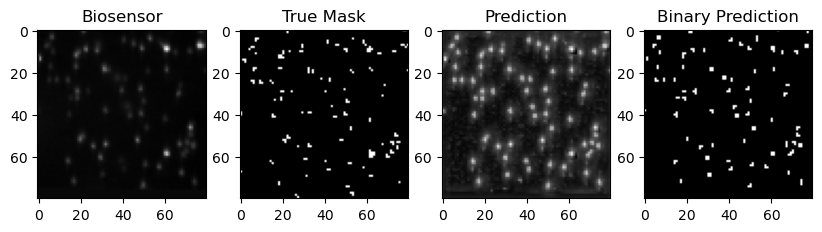

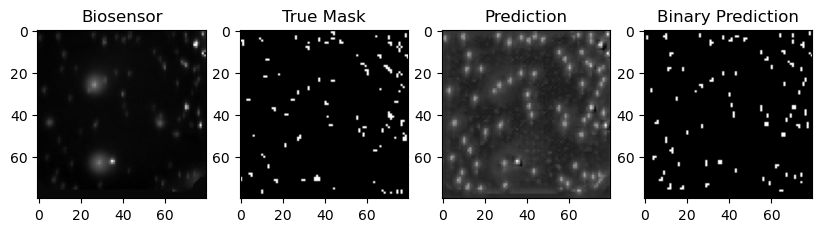

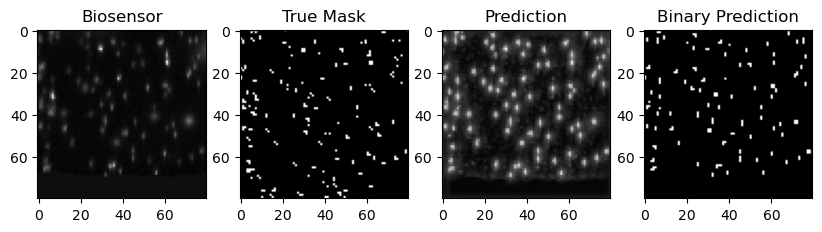

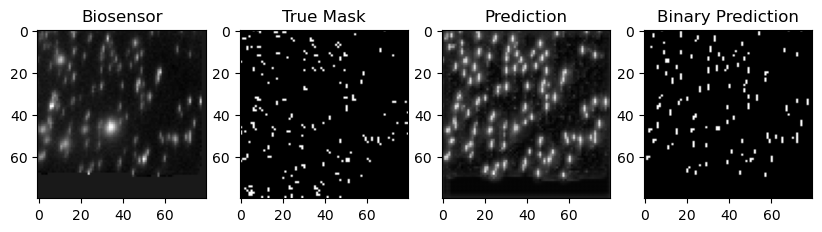

In [27]:
# Load a batch of data and labels
loader_iter = iter(test_loader)
data, labels = next(loader_iter)
data, labels = next(loader_iter)
data, labels = next(loader_iter)

# Move the data and labels to the device
data = data.to(device)
labels = labels.to(device)

# Get the predictions
predictions = model(data)

# Move the predictions and labels to the CPU and convert them to numpy arrays
predictions = predictions.cpu().detach().numpy()
threshold = 0.5
binary_predictions = (predictions > threshold).astype(np.uint8)


labels = labels.cpu().numpy()

# Plot the data, the labels, and the predictions
for i in range(len(data)):
    plt.figure(figsize=(10, 40))
    
    plt.subplot(1, 4, 1)
    plt.imshow(data[i].cpu().numpy()[-1], cmap='gray')
    plt.title('Biosensor')
    
    plt.subplot(1, 4, 2)
    plt.imshow(np.squeeze(labels[i]), cmap='gray')
    plt.title('True Mask')
    
    plt.subplot(1, 4, 3)
    plt.imshow(np.squeeze(predictions[i]), cmap='gray')
    plt.title('Prediction')

    plt.subplot(1, 4, 4)
    plt.imshow(np.squeeze(binary_predictions[i]), cmap='gray')
    plt.title('Binary Prediction')
    
    plt.show()

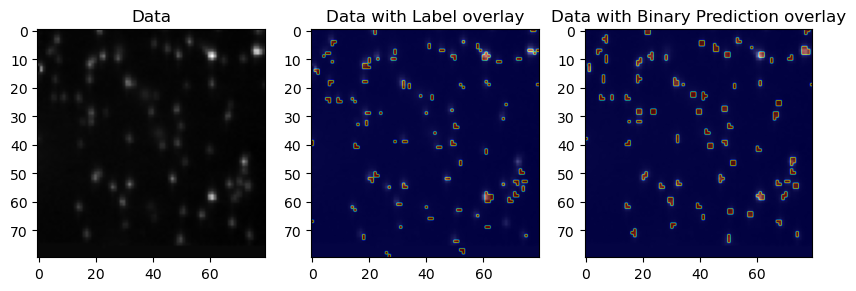

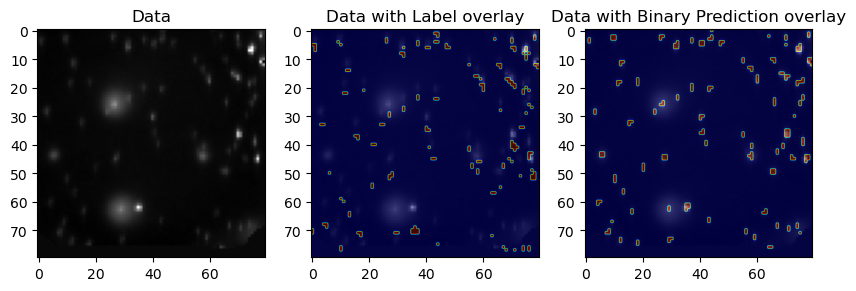

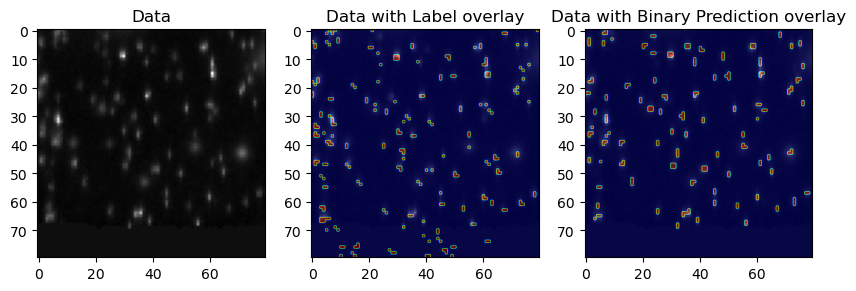

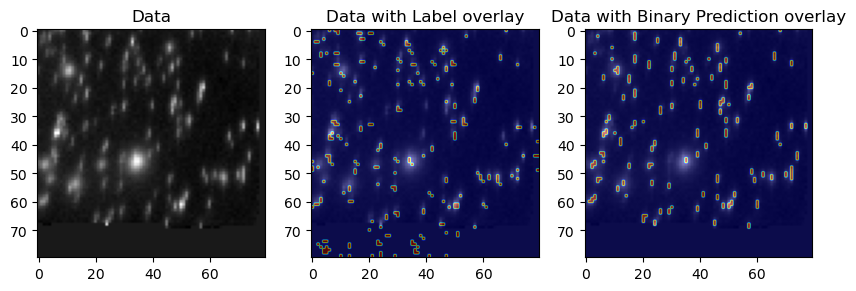

In [6]:
# Plot the data, the labels, and the predictions
for i in range(len(data)):
    plt.figure(figsize=(10, 10))
    
    plt.subplot(1, 3, 1)
    plt.imshow(data[i].cpu().numpy()[-1], cmap='gray')
    plt.title('Data')
    
    plt.subplot(1, 3, 2)
    plt.imshow(data[i].cpu().numpy()[-1], cmap='gray')
    plt.imshow(np.squeeze(labels[i]), cmap='jet', alpha=0.5)
    plt.title('Data with Label overlay')
    
    plt.subplot(1, 3, 3)
    plt.imshow(data[i].cpu().numpy()[-1], cmap='gray')
    plt.imshow(np.squeeze(binary_predictions[i]), cmap='jet', alpha=0.5)
    plt.title('Data with Binary Prediction overlay')
    
    plt.show()

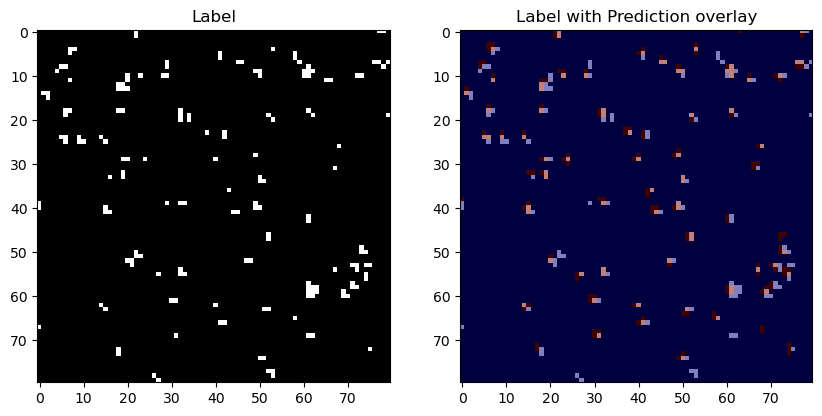

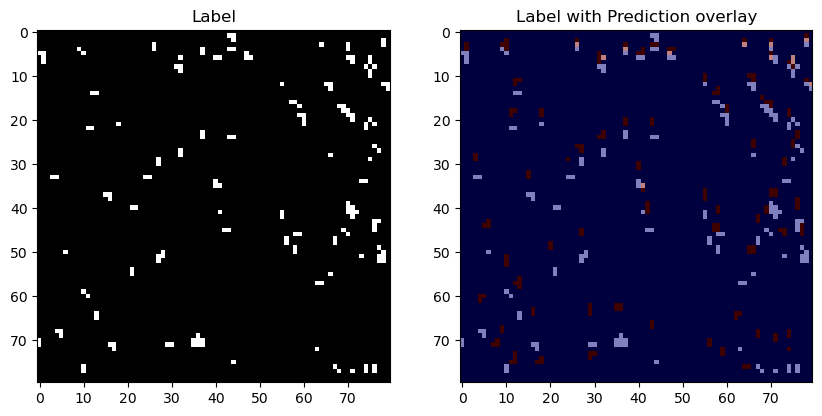

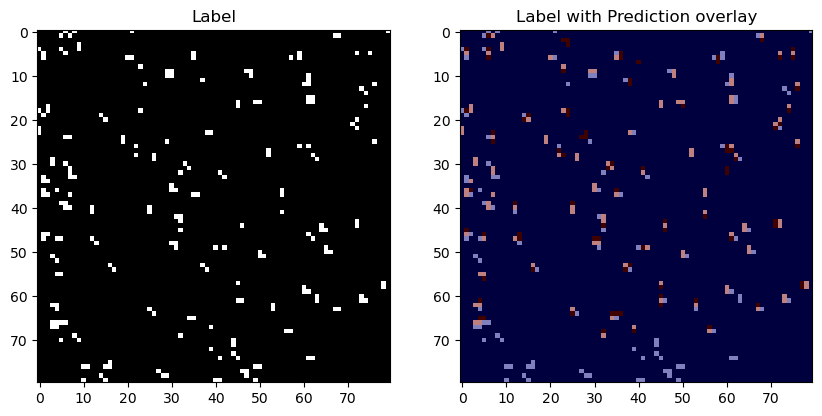

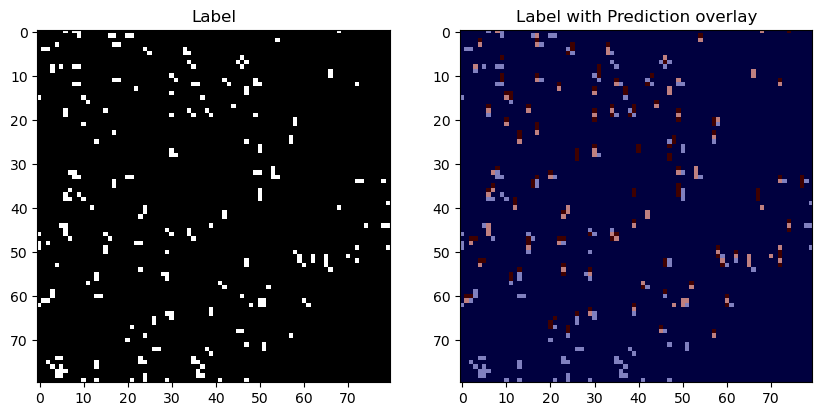

In [36]:
# Plot the label and the prediction
for i in range(len(labels)):
    plt.figure(figsize=(10, 10))
    
    plt.subplot(1, 2, 1)
    plt.imshow(np.squeeze(labels[i]), cmap='gray')
    plt.title('Label')
    
    plt.subplot(1, 2, 2)
    plt.imshow(np.squeeze(labels[i]), cmap='gray')
    plt.imshow(np.squeeze(binary_predictions[i]), cmap='jet', alpha=0.5)
    plt.title('Label with Prediction overlay')
    
    plt.show()

In [8]:
def cell_detection_skimage(model, val_loader, device, threshold=0.5):
    model.eval()  # Set the model to evaluation mode

    total_cells = 0
    detected_cells = 0

    with torch.no_grad():  # Disable gradient calculation
        for data, labels in val_loader:
            # Move the data and labels to the device
            data = data.to(device)
            labels = labels.to(device)

            # Get the predictions
            predictions = model(data)

            # Move the predictions and labels to the CPU and convert them to numpy arrays
            predictions = predictions.cpu().detach().numpy()
            binary_predictions = (predictions > threshold).astype(np.uint8)

            labels = labels.cpu().numpy()

            for i in range(len(data)):
                # Label the binary prediction and count the number of cells
                _, num_cells_pred = skimage.measure.label(binary_predictions[i], return_num=True, connectivity=2)
                _, num_cells_label = skimage.measure.label(labels[i], return_num=True, connectivity=2)

                total_cells += num_cells_label
                detected_cells += num_cells_pred

    cell_detection_rate = detected_cells / total_cells if total_cells > 0 else 0

    return cell_detection_rate, total_cells, detected_cells

In [12]:
def cell_detection_scipy(model, val_loader, device, threshold=0.5):
    model.eval()  # Set the model to evaluation mode

    total_cells = 0
    detected_cells = 0

    with torch.no_grad():  # Disable gradient calculation
        for data, labels in val_loader:
            # Move the data and labels to the device
            data = data.to(device)
            labels = labels.to(device)

            # Get the predictions
            predictions = model(data)

            # Move the predictions and labels to the CPU and convert them to numpy arrays
            predictions = predictions.cpu().detach().numpy()
            binary_predictions = (predictions > threshold).astype(np.uint8)

            labels = labels.cpu().numpy()

            structure = np.ones((3, 3))

            for i in range(len(data)):
                # Label the binary prediction and count the number of cells
                _, num_cells_pred = scipy.ndimage.label(np.squeeze(binary_predictions[i]), structure=structure)
                _, num_cells_label = scipy.ndimage.label(labels[i], structure=structure)

                total_cells += num_cells_label
                detected_cells += num_cells_pred

    cell_detection_rate = detected_cells / total_cells if total_cells > 0 else 0

    return cell_detection_rate, total_cells, detected_cells

In [9]:
def pos_pixels(model, val_loader, device, threshold=0.5):
    model.eval()  # Set the model to evaluation mode

    total_cells = 0
    detected_cells = 0

    with torch.no_grad():  # Disable gradient calculation
        for data, labels in val_loader:
            # Move the data and labels to the device
            data = data.to(device)
            labels = labels.to(device)

            # Get the predictions
            predictions = model(data)

            # Move the predictions and labels to the CPU and convert them to numpy arrays
            predictions = predictions.cpu().detach().numpy()
            binary_predictions = (predictions > threshold).astype(np.uint8)

            labels = labels.cpu().numpy()

            total_cells += np.sum(labels)
            detected_cells += np.sum(binary_predictions)

    return total_cells, detected_cells

In [34]:
label, detected = pos_pixels(model, test_loader, device, threshold=0.5)
print(label, detected)

9485 6677


In [35]:
cell_detection_rate, total, detected = cell_detection_skimage(model, test_loader, device)
print(f'Cell detection rate: {cell_detection_rate}, total cells: {total}, detected cells: {detected}')

Cell detection rate: 0.7451589768109013, total cells: 4183, detected cells: 3117


In [30]:
cell_detection_rate, total, detected = cell_detection_scipy(model, test_loader, device)
print(f'Cell detection rate: {cell_detection_rate}, total cells: {total}, detected cells: {detected}')

Cell detection rate: 0.8187903418599092, total cells: 4183, detected cells: 3425
